<a href="https://colab.research.google.com/github/q-maze/location-affordability-tool/blob/main/Geopandas_for_User_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive') #authorization code

Mounted at /content/drive


In [2]:
!pip install geopandas
import geopandas

     |████████████████████████████████| 1.0MB 11.9MB/s 
     |████████████████████████████████| 6.5MB 34.4MB/s 
     |████████████████████████████████| 15.3MB 269kB/s 


In [3]:
!pip install mapclassify
from mapclassify import __version__ as mc_version

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:


class LocationAffordabilityIndex:
    # constructor for class, takes one argument csv_file_path
    # if filepath variable is not supplied, retrieves fresh csv from URL
    def __init__(self, lai_data_loc='https://opendata.arcgis.com/datasets/8eaa0b89826244ae9246915199462328_0.csv',
                 fips_d_loc='https://www2.census.gov/programs-surveys/popest/geographies/2016/all-geocodes-v2016.xlsx'):
        self.lai_csv_file_path = lai_data_loc
        self.fips_data_file_path = fips_d_loc

        # read in LAI data from chosen data source
        self.df = pd.read_csv(self.lai_csv_file_path)

        # format the LAI data for state and county to match formatting from country fips data set
        self.df['BlockGroups_COUNTYFP10'] = self.df['BlockGroups_COUNTYFP10'].astype(str)
        self.df['BlockGroups_STATEFP10'] = self.df['BlockGroups_STATEFP10'].astype(str)
        self.df['BlockGroups_COUNTYFP10'] = self.df['BlockGroups_COUNTYFP10'].apply(lambda x: x.zfill(3))
        self.df['BlockGroups_STATEFP10'] = self.df['BlockGroups_STATEFP10'].apply(lambda x: x.zfill(2))
        # then add a column concat of the state and county
        self.df['State-County'] = self.df['BlockGroups_STATEFP10'] + self.df['BlockGroups_COUNTYFP10']

        # merge the two data sets
        fips = self.get_county_names()
        self.df = self.df.merge(fips, how='left',
                                on='State-County')
        self.user = None
        self.by_county = None

    # function to output current main dataframe to a csv file in the local directory
    def to_csv(self, filename='LAI.csv'):
        self.df.to_csv(filename)

    # function to create a smaller csv (500 lines) of random lines from df in the local directory
    def to_smaller_csv(self, filename='smaller_LAI.csv'):
        smaller_df = self.df.sample(n=500)
        smaller_df.to_csv(filename)

    def store_fips(self):
        fips = self.get_county_names()
        fips.to_excel('all-geocodes-v2016.xlsx')

    # Returns a dataframe containing FIPS State-County Code and associated county name
    def get_county_names(self):
        # read in the excel file from the supplied location or if none supplied, Census URL
        if self.fips_data_file_path.endswith('.xlsx'):
            fips_df = pd.read_excel(self.fips_data_file_path,
                                    header=None,
                                    index_col=None,
                                    engine='openpyxl')
        else:
            fips_df = pd.read_csv(self.fips_data_file_path)
        # rename the columns to something nice
        # NOTE: ALL COLUMNS LABELED IN CASE WE WANT TO ADD FINER DETAIL (PLACE, CITY) TO APPLICATION LATER
        fips_df.columns = ['Sum_Lvl', 'State',
                           'County', 'Subdivision',
                           'Place', 'City',
                           'Area_Name']
        fips_df = fips_df.iloc[6:].reset_index()  # chop off the info rows at top of document

        # Queries the dataframe to only show the county names (can be removed for places later if needed)
        fips_df = fips_df.query('Sum_Lvl == "050" & Subdivision == "00000" & Place == "00000" & City == "00000"')
        fips_df = fips_df.iloc[:, 1:8].reset_index()
        # creates a state-county concatenation to search in LAI data
        fips_df['State-County'] = fips_df['State'] + fips_df['County']
        # returns only the state-county and area_name, which in this config is only the county names
        fips_df = fips_df[['State-County', 'Area_Name']].copy()
        return fips_df

    # adds a user profile column indicating if each area is affordable for the user to live in
    # we defined affordability to be if the median income in the area for the users classification was less than
    # 120% of the users income
    def add_user_prof(self, user):
        self.user = user
        self.by_county = self.df.groupby(['SF1_BlockGroups_ST_ABBREV','State-County']).mean().reset_index()
        self.by_county['affordable_area'] = np.where(
            self.by_county['hh_' + self.user.classification + '_income'] > self.user.income * 1.2,
            'na',
            'a')

    def show_affordable_locations(self):
        # columns to be returned to all users regardless of classification
        global_result_columns = ['SF1_BlockGroups_STATE_NAME',
                                 'SF1_BlockGroups_ST_ABBREV',
                                 'Area_Name',
                                 'affordable_area',
                                 'residential_density',
                                 'gross_hh_density',
                                 'block_denstiy',
                                 'intersection_density',
                                 'employment_access_index',
                                 'job_diversity_index',
                                 'average_median_commute_distance',
                                 'per_capita_income',
                                 'State-County']
        # makes a copy of the by_county instance variable to work on
        result_df = self.by_county
        # selects only the state the user is interested in and only the areas which have been deemed affordable
        result_df = result_df[result_df['SF1_BlockGroups_ST_ABBREV'] == self.user.state]
        result_df = result_df[result_df['affordable_area'] == 'a']
        # creates a list of columns that containt the user's classification (type1, 7, 8)
        user_classification_cols = [col for col in result_df.columns if self.user.classification in col]
        # creates a list of all columns to be returned
        result_columns = global_result_columns + user_classification_cols
        # adds the columns to the result dataframe
        result_df = result_df[result_df.columns & result_columns]
        # creates a county 
        #result_df['county'] = result_df['State-County'].str[-3:] not needed at moment due to State-County merge with geopandas
        # sorts by per capita income
        result_df = result_df.sort_values(by='per_capita_income')
        return result_df
class LAIUser:
    # receives user input from strings and saves them to instance variables
    def __init__(self, state, income, living, work, household, transport):
        self.state = state
        self.income = income
        self.living = living
        self.work = work
        self.household = household
        self.transport = transport
        self.classification = None

    # classifies a user as single, retired or dual income.
    # classifies user into one of the following types:
    # type 1 - Dual Income
    # type 7 - Single Worker
    # type 8 - Retirees
    def classify_user(self):
        if self.work == 'no':
            if self.household == 'single':
                self.classification = 'type7'
            else:
                self.classification = 'type1'
        else:
            self.classification = 'type8'

def get_filters():
    state_data = {'alabama': 'AL', 'alaska': 'AK', 'arizona': 'AZ', 'arkansas': 'AZ', 'california': 'CA',
                  "colorado": 'CO', 'connecticut': 'CT', 'delaware': 'DE', 'florida': 'FL', 'georgia': 'GA',
                  'hawaii': 'HI', 'idaho': 'ID', 'illinois': 'IL', 'indiana': 'IN', 'iowa': 'IA', 'kansas': 'KS',
                  'kentucky': 'KY', 'louisiana': 'LA', 'maine': 'ME', 'maryland': 'MD',
                  'massachusetts': 'MA', 'michigan': 'MI', 'minnesota': 'MN', 'mississippi': 'MS', 'missouri': 'MO',
                  'montana': 'MT', 'nebraska': 'NE', 'nevada': 'NV', 'New Hampshire': 'NH',
                  'new jersey': 'NJ', 'new mexico': 'NM', 'new york': 'NY', 'north carolina': 'NC',
                  'north dakota': 'ND', 'ohio': 'OH', 'oklahoma': 'OK', 'oregon': 'OR',
                  'pennsylvania': 'PA', 'rhode island': 'RI', 'south carolina': 'SC', 'south dakota': 'SD',
                  'tennesee': 'TN', 'texas': 'TX', 'utah': 'UT', 'vermont': 'VT', 'virginia': 'VA', 'washington': 'WA',
                  'west virginia': 'WV', 'wisconsin': 'WI', 'wyoming': 'WY', 'washington dc': 'dc'}
    # Grab all inputs of the user
    print('Hello! Let\'s find you an affordable place!')
    # Get user's State
    while True:
        try:
            state = str(input('Please enter a State you are interested in: ').lower())
            if state in state_data.keys():
                state = state_data.get(state)
                break
            print("Please enter a valid state")
        except Exception as e:
            print(e)

    # Get user income level
    while True:
        try:
            income = int(input('Please enter your income: '))
            if income >= 0:
                break
            print("Please enter a valid income")
        except Exception as e:
            print(e)

    # Are you planning on owning a home or renting
    while True:
        try:
            living = str(input('Are you planning on Renting or Owning a Home?\
            \nEnter Renting or Owning: ').lower())
            if living == 'renting' or living == 'owning':
                break
            print("Invalid Answer Entered")
        except Exception as e:
            print(e)

    # Are you Retired or Working
    while True:
        try:
            work = str(input('Are you Retired?\
            \nEnter Yes or No: ').lower())
            if work == 'yes' or work == 'no':
                break
            print("Invalid Answer Entered")
        except Exception as e:
            print(e)

    # If not retired, type of household
    if work == 'no':
        while True:
            try:
                household = str(input('Single or Dual Income?\
                \nEnter Single or Dual: ').lower())
                if household == 'single' or household == 'dual':
                    break
                print("Invalid Answer Entered")
            except Exception as e:
                print(e)
    else:
        household = 'retired'

    # Prefer Public Transit or Driving
    while True:
        try:
            transport = str(input('Do you prefer Public Transit or Driving?\
            \nEnter Public Transit or Driving: ').lower())
            if transport == 'public transit' or transport == 'driving':
                break
            print("Invalid Answer Entered")
        except Exception as e:
            print(e)

    print('-' * 40)

    user = LAIUser(state, income, living, work, household, transport)
    user.classify_user()

    return user


In [6]:
LAI = LocationAffordabilityIndex()

In [11]:
user_1 = get_filters()
LAI.add_user_prof(user_1)
result_1 = LAI.show_affordable_locations()

Hello! Let's find you an affordable place!
Please enter a State you are interested in: CA
Please enter a valid state
Please enter a State you are interested in: california
Please enter your income: 100000
Are you planning on Renting or Owning a Home?            
Enter Renting or Owning: renting
Are you Retired?            
Enter Yes or No: no
Single or Dual Income?                
Enter Single or Dual: dual
Do you prefer Public Transit or Driving?            
Enter Public Transit or Driving: driving
----------------------------------------


,SF1_BlockGroups_ST_ABBREV,State-County,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,affordable_area
198,CA,06025,3.301543,2.044252,0.091515,0.182436,6568.075215,2753.776979,24.514629,12612.962224,38685.0,3.34,1.05544,63.158579,33.441469,71.746257,42.029147,52.207501,22.490391,29.717110,1.812402,24283.909153,47.077272,a
209,CA,06047,2.825268,1.764406,0.082897,0.189987,6871.193826,2783.649535,21.541389,13941.066836,43844.0,3.36,1.17510,61.394916,33.501934,70.497357,42.604376,51.009440,23.116459,27.892981,1.891782,25023.110875,18.837700,a
239,CA,06107,2.638713,1.598224,0.109534,0.238622,8511.867283,3345.485634,14.525975,14431.117511,43851.0,3.35,1.21450,58.257990,30.437366,64.694294,36.873670,49.560585,21.739962,27.820624,1.908195,24621.670990,19.571495,a
205,CA,06039,1.995426,1.073548,0.069347,0.145465,4790.005425,2760.576015,20.375675,14866.904634,46039.0,3.30,0.97068,62.098461,34.563141,69.746027,42.210707,51.098573,23.563254,27.535320,1.947493,26203.024420,0.271261,a
237,CA,06103,1.912400,0.611922,0.058350,0.099419,2073.344166,2739.212777,22.572999,15388.310460,38137.0,2.60,0.87513,67.994945,36.086784,75.013144,43.104983,57.260028,25.351867,31.908162,1.854641,26868.146215,4.573454,a
201,CA,06031,2.821102,1.707694,0.135443,0.272668,5982.643893,3118.593800,19.544708,15934.677205,48684.0,3.30,1.18557,54.699208,29.245958,61.228001,35.774751,46.295546,20.842296,25.453250,1.924692,25154.319148,28.133038,a
202,CA,06033,1.381554,0.547939,0.052583,0.117217,1750.871702,2445.071593,17.953694,16271.003577,39491.0,2.53,0.84444,74.001795,43.581666,81.861626,51.441497,56.403203,25.983074,30.420129,1.881606,25730.966218,11.325897,a
195,CA,06019,3.363176,2.506859,0.103108,0.241328,19108.083861,2758.779589,11.546813,16575.795065,46430.0,3.14,1.16903,55.328149,31.008198,62.251035,37.931084,47.881655,23.561704,24.319951,1.824327,21778.715435,58.681158,a
200,CA,06029,3.198645,2.265291,0.097133,0.226050,13356.950901,2889.217002,16.814860,16753.238128,47089.0,3.14,1.13820,54.754169,30.195006,59.675166,35.116002,47.555011,22.995847,24.559164,1.846291,22694.345171,32.755476,a
243,CA,06115,2.685954,1.477858,0.080894,0.174994,5300.255362,2626.652010,31.293549,17443.719598,49190.0,2.94,1.09817,58.155082,32.206152,64.372500,38.423570,48.280876,22.331946,25.948930,1.945169,26569.966669,13.484664,a


In [13]:
# path of the county shapefile 
path='/content/drive/MyDrive/CountyShapefile' # change based on where user Shapefiles are saved

# load the shape file using geopandas
geo_county = geopandas.read_file(path)

# rename columns
geo_county.columns=['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'State-County', 'county', 'LSAD',
       'ALAND', 'AWATER', 'geometry']

geo_county['State-County'] = pd.to_numeric(geo_county["State-County"], downcast='integer')
result_1['State-County'] = pd.to_numeric(result_1["State-County"], downcast='integer')

# merge cb_2016_us_county_20m file with usa dta 
geo_county_1=geo_county.merge(result_1,on='State-County').dropna(axis=0).sort_values(by='per_capita_income',ascending=False).reset_index()
geo_county_table_1 = geo_county_1.drop(geo_county_1.columns[0:6], axis=1)
geo_county_table_1 = geo_county_table_1.drop(geo_county_table_1.columns[1:5], axis=1)
geo_county_table_1 = geo_county_table_1.drop(geo_county_table_1.columns[3:6], axis=1)
geo_county_table_1 = geo_county_table_1.rename(columns={'SF1_BlockGroups_ST_ABBREV': 'State',})
geo_county_table_1

,county,State,residential_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,affordable_area
0,Marin,CA,3.539425,17822.673815,2207.741580,14.055059,42372.507557,75707.0,2.62,1.20183,50.038276,34.007753,55.225013,39.194490,40.849520,24.818997,16.030523,1.935524,22059.792519,56.972236,a
1,San Mateo,CA,6.287540,36876.134590,2025.197985,11.111265,36793.876572,75707.0,2.62,1.20183,48.424445,33.899671,53.544030,39.019256,39.050638,24.525864,14.524774,1.764026,19467.040070,104.068238,a
2,San Francisco,CA,23.346612,146367.492785,2404.598999,4.193474,35209.771190,75707.0,2.62,1.20183,38.316390,28.639834,48.750475,39.073919,31.617507,21.940951,9.676556,1.100089,10497.375861,605.375867,a
3,Santa Clara,CA,5.664153,44888.156073,2059.957132,9.205184,33911.361850,86286.0,2.87,1.28995,42.553823,29.368732,47.282859,34.097769,34.734769,21.549679,13.185091,1.894106,19290.300574,83.022130,a
4,Contra Costa,CA,4.249327,22707.919295,2201.025335,16.276580,31348.426644,75707.0,2.62,1.20183,48.403633,32.996717,52.936244,37.529328,38.164676,22.757760,15.406916,1.875178,20798.818420,77.879352,a
5,Napa,CA,3.254543,12182.007951,2645.502728,13.297292,30072.470345,67389.0,2.61,1.15277,52.335511,34.444217,59.820807,41.929514,40.241270,22.349976,17.891293,1.911196,22268.134068,48.853464,a
6,Placer,CA,2.450399,12713.882087,2282.069285,21.683346,29597.735996,60330.0,2.66,1.11390,57.588884,36.977117,62.819617,42.207850,45.055275,24.443508,20.611767,1.917997,23965.408066,25.015441,a
7,Orange,CA,5.924068,57044.334551,2161.988014,11.350541,28864.357539,59876.0,2.97,1.29564,56.205141,38.614659,62.487502,44.897020,47.944160,30.353677,17.590483,1.805343,18535.272783,76.715891,a
8,Alameda,CA,8.061485,45412.227672,2167.576643,11.530724,28439.821507,75707.0,2.62,1.20183,44.103398,30.310262,51.273103,37.479968,35.340614,21.547478,13.793136,1.702141,17516.097884,177.137534,a
9,Sonoma,CA,3.388357,12291.105391,2366.932688,12.304840,27362.996012,63274.0,2.52,1.11801,54.255438,35.545001,60.555902,41.845466,43.484655,24.774219,18.710437,1.872450,22035.683538,25.543293,a


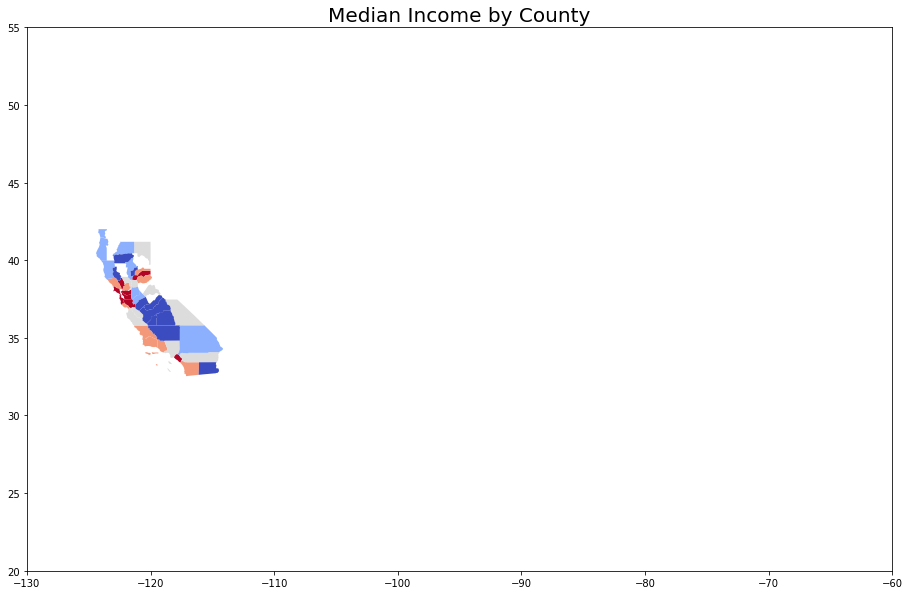

In [15]:
# plot
geo_county_1.plot(column='per_capita_income',scheme="quantiles",figsize=(25,10),cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Median Income by County',fontsize=20)
# add state borders
# zoom on state
plt.show()

In [14]:
user_2 = get_filters()
LAI.add_user_prof(user_2)
result_2 = LAI.show_affordable_locations()

result_2['State-County'] = pd.to_numeric(result_2["State-County"], downcast='integer')

# merge cb_2016_us_county_20m file with usa dta 
geo_county_2=geo_county.merge(result_2,on='State-County').dropna(axis=0).sort_values(by='per_capita_income',ascending=False).reset_index()
geo_county_table_2 = geo_county_2.drop(geo_county_2.columns[0:6], axis=1)
geo_county_table_2 = geo_county_table_2.drop(geo_county_table_2.columns[1:5], axis=1)
geo_county_table_2 = geo_county_table_2.drop(geo_county_table_2.columns[3:6], axis=1)
geo_county_table_2 = geo_county_table_2.rename(columns={'SF1_BlockGroups_ST_ABBREV': 'State',})
geo_county_table_2

Hello! Let's find you an affordable place!
Please enter a State you are interested in: virginia
Please enter your income: 80000
Are you planning on Renting or Owning a Home?            
Enter Renting or Owning: owning
Are you Retired?            
Enter Yes or No: no
Single or Dual Income?                
Enter Single or Dual: single
Do you prefer Public Transit or Driving?            
Enter Public Transit or Driving: public transit
----------------------------------------


,county,State,residential_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,affordable_area
0,Arlington,VA,14.957095,112143.111406,1874.155961,5.122291,48514.203026,32446.96970,1.0,1.0,74.240611,58.343627,88.448224,72.551240,63.670151,47.773167,15.896984,0.881721,7838.684115,498.733473,a
1,Falls Church,VA,4.582365,64789.022471,1886.316264,7.372206,47784.279594,32446.96970,1.0,1.0,81.691764,63.386271,95.411215,77.105721,64.193040,45.887548,18.305494,1.064643,9861.050115,300.174421,a
2,Alexandria,VA,12.710638,80992.308394,1858.639640,6.498168,44757.756019,32446.96970,1.0,1.0,70.786072,54.106446,84.989932,68.310306,59.265113,42.585488,16.679625,0.953965,8628.484314,377.088798,a
3,Fairfax,VA,4.730593,47228.652415,2000.971829,9.882084,42493.670176,32446.96970,1.0,1.0,81.587228,61.653605,87.979761,68.046138,71.747966,51.814342,19.933624,1.149311,11694.716722,194.618045,a
4,Fairfax,VA,2.828022,53032.772367,1856.103553,8.681199,40213.242875,32446.96970,1.0,1.0,76.559708,56.866969,81.322025,61.629288,65.815523,46.122785,19.692736,1.152285,11272.242808,193.107937,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Henry,VA,1.259702,3265.507475,2257.968477,9.318480,14879.384611,14315.74468,1.0,1.0,112.535498,54.376081,118.108626,59.949210,96.883117,38.723701,58.159416,1.445269,18193.046561,3.527868,a
82,Scott,VA,1.074918,2264.149720,2394.549566,14.623991,14496.867964,16341.55844,1.0,1.0,100.530093,46.512197,107.614009,53.596114,80.220720,26.202823,54.017895,1.450447,20518.536313,2.489870,a
83,Danville,VA,2.023034,8767.467588,2863.534141,10.056169,14223.501075,15508.40708,1.0,1.0,97.384121,51.132839,108.700077,62.448796,84.691114,38.439832,46.251281,1.317941,14571.812594,5.686829,a
84,Petersburg,VA,2.268325,9345.350665,2585.351305,15.674679,14069.026165,22744.26877,1.0,1.0,73.436983,42.474018,86.596463,55.633496,63.180838,32.217871,30.962967,1.214399,14440.949554,34.586186,a


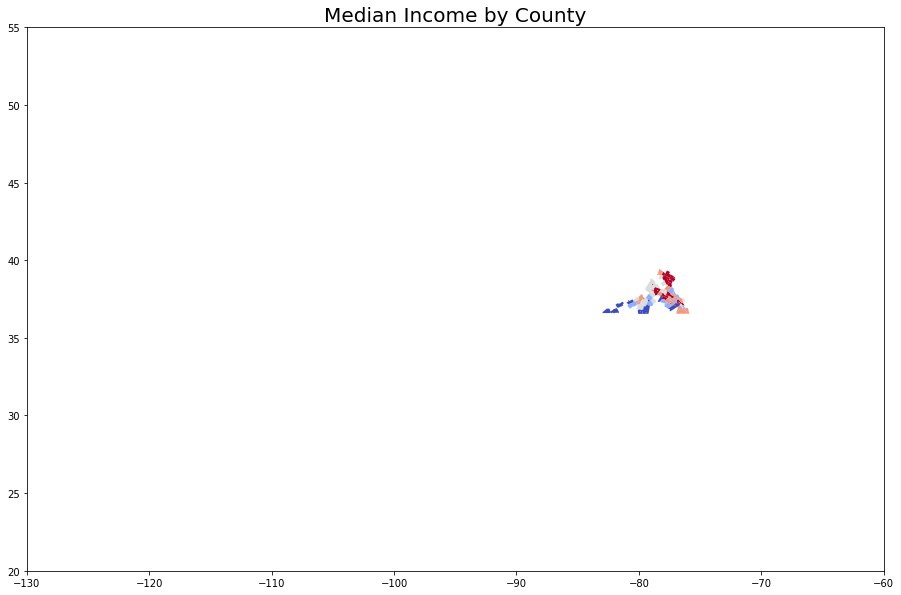

In [16]:
# plot
geo_county_2.plot(column='per_capita_income',scheme="quantiles",figsize=(25,10),cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Median Income by County',fontsize=20)
# add state borders
# zoom on state
plt.show()

In [ ]:
# highest income neighborhood
geo_county_table.sort_values("per_capita_income", ascending=False).head(25)

,county,Object_ID,2010_Census_Geoid,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type2_income,hh_type2_size,hh_type2_workers,hh_type2_ht,hh_type2_h,hh_type2_ht_own,hh_type2_h_own,hh_type2_ht_rent,hh_type2_h_rent,hh_type2_t,hh_type2_autos,hh_type2_vmt,...,hh_type6_size,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area
0,Palm Beach,48698,120990035041,1,1.209900e+08,Florida,FL,1.22744,0.57627,0.05846,0.11275,2.104539e+04,2039.80551,2.87220,157233.33333,48839.0,2.66,1.16571,87.83812,65.91025,101.78208,79.85421,51.58383,29.65596,21.92787,1.84069,20413.80261,21.15845,39071.2,2.66,1.16571,107.23097,81.68847,125.36027,99.81777,60.09480,34.55230,25.54250,1.75581,19855.37751,...,1.0,1.0,106.90070,86.91654,126.19027,106.20611,56.74782,36.76365,19.98417,1.32661,13983.22328,27.11790,18360.52632,1.0,1.0,209.05760,173.83307,247.63674,212.41221,108.75183,73.52730,35.22453,1.18760,12943.17327,28.43333,39071.2,2.0,0.0,99.31570,81.68847,117.44500,99.81777,52.17954,34.55230,17.62723,1.28640,12318.86168,61.94509,0.228682,0.000264
1,Lee,45468,120710802032,2,1.207108e+08,Florida,FL,1.28180,1.02218,0.01319,0.12530,2.024636e+03,2961.27839,11.51710,148610.86957,50014.0,2.44,0.95361,101.40671,77.97817,101.40671,77.97817,46.30168,22.87313,23.42855,1.88341,24652.62307,0.00000,40011.2,2.44,0.95361,125.73516,97.47271,125.73516,97.47271,54.95974,26.69729,28.26245,1.79906,24108.34090,...,1.0,1.0,117.82721,95.13336,117.82721,95.13336,45.86693,23.17308,22.69385,1.49430,19591.53943,0.00000,20497.54098,1.0,1.0,230.80342,190.26673,230.80342,190.26673,77.99467,37.45798,40.53670,1.34331,18519.57259,0.00000,40011.2,2.0,0.0,119.70757,97.47271,119.70757,97.47271,46.97408,24.73922,22.23486,1.48729,17737.21727,0.00000,0.070063,0.000056
2,New York,135542,360610114012,2,3.606101e+08,New York,NY,18.86742,18.86744,0.32956,0.82391,1.183129e+06,1831.89117,1.45680,147929.58580,63915.0,2.69,1.20119,33.80061,24.76874,41.88801,32.85614,29.02680,19.99493,9.03188,0.82409,7431.88118,1081.06081,51132.0,2.69,1.20119,40.05513,29.75795,51.36736,41.07017,33.37778,23.08059,10.29719,0.75105,6897.10115,...,1.0,1.0,37.23143,31.01772,50.40522,44.19150,29.45524,23.24153,6.21371,0.35884,3692.98031,840.47952,23760.22305,1.0,1.0,69.75651,59.80051,98.33901,88.38301,52.88489,42.92889,9.95600,0.25840,2736.47472,850.30194,51132.0,2.0,0.0,36.94429,28.15817,49.85630,41.07017,29.32262,20.53649,8.78612,0.61110,5167.37378,1154.98514,0.009672,0.000005
3,Miami-Dade,46689,120860040006,6,1.208600e+08,Florida,FL,3.14868,2.58035,0.16514,0.20643,3.747828e+04,3754.23053,5.32537,136931.44654,48839.0,2.66,1.16571,72.60768,55.28369,72.60768,55.28369,37.68362,20.35963,17.32399,1.51094,14458.30190,207.52779,39071.2,2.66,1.16571,89.07756,69.10461,89.07756,69.10461,43.72528,23.75233,19.97295,1.42914,13913.19858,...,1.0,1.0,88.25379,73.52730,88.25379,73.52730,36.72670,22.00022,14.72648,1.03478,8831.79246,168.68656,18360.52632,1.0,1.0,172.18241,147.05461,172.18241,147.05461,60.63781,35.51000,25.12781,0.90530,7833.12367,171.02352,39071.2,2.0,0.0,83.15412,69.10461,83.15412,69.10461,36.80935,22.75984,14.04951,1.10828,7833.73449,223.78541,0.0179

In [ ]:
file = 'https://opendata.arcgis.com/datasets/8eaa0b89826244ae9246915199462328_0.csv'
data = pd.read_csv(file)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219829 entries, 0 to 219828
Columns: 123 entries, FID to SHAPE_Area
dtypes: float64(115), int64(6), object(2)
memory usage: 206.3+ MB
None


In [ ]:
data = data.rename(columns={'FID': 'Object_ID', 'BlockGroups_GEOID10': '2010_Census_Geoid', 'BlockGroups_STATEFP10': 'State_ID', 'BlockGroups_COUNTYFP10': 'County_ID', 'SF1_BlockGroups_NAME': 'Name','SF1_BlockGroups_STATE_NAME': 'State', 'SF1_BlockGroups_ST_ABBREV': 'State_ABBREV'})
#data = data.drop(data.columns[4:6], axis=1)

# drop very low income because it is the same for every neighborhood
data = data.drop(data.columns[69:82], axis=1)


# or fillna with mean
#data = data.fillna(data.mean)

# add leading zeros to IDs
data["State_ID"]=data["State_ID"].astype(str).apply(lambda x: x.zfill(2))
data["County_ID"]=data["County_ID"].astype(str).apply(lambda x: x.zfill(3))

# combine state & county ID 
data["State-County"]=data["State_ID"].astype(str) + data["County_ID"].astype(str)
data["State-County"] = pd.to_numeric(data["State-County"], downcast='integer')

# drop Hawaii, Alaska, and DC
data_cont = data.drop(data[(data['State']=='Hawaii') | (data['State']== 'Alaska') | (data['State']== 'District of Columbia')].index)
print(data_cont.info())

#filter for NaN 
data_cont = data_cont.dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217995 entries, 0 to 219828
Columns: 111 entries, Object_ID to State-County
dtypes: float64(102), int32(1), int64(4), object(4)
memory usage: 185.4+ MB
None


In [ ]:
# lowest income neighborhoods
geo_county_table.sort_values("per_capita_income", ascending=True).head(25)

,county,Object_ID,2010_Census_Geoid,BlockGroups_BLKGRPCE10,Name,State,State_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,hh_type2_income,hh_type2_size,hh_type2_workers,hh_type2_ht,hh_type2_h,hh_type2_ht_own,hh_type2_h_own,hh_type2_ht_rent,hh_type2_h_rent,hh_type2_t,hh_type2_autos,hh_type2_vmt,...,hh_type6_size,hh_type6_workers,hh_type6_ht,hh_type6_h,hh_type6_ht_own,hh_type6_h_own,hh_type6_ht_rent,hh_type6_h_rent,hh_type6_t,hh_type6_autos,hh_type6_vmt,hh_type6_transit_trips,hh_type7_income,hh_type7_size,hh_type7_workers,hh_type7_ht,hh_type7_h,hh_type7_ht_own,hh_type7_h_own,hh_type7_ht_rent,hh_type7_h_rent,hh_type7_t,hh_type7_autos,hh_type7_vmt,hh_type7_transit_trips,hh_type8_income,hh_type8_size,hh_type8_workers,hh_type8_ht,hh_type8_h,hh_type8_ht_own,hh_type8_h_own,hh_type8_ht_rent,hh_type8_h_rent,hh_type8_t,hh_type8_autos,hh_type8_vmt,hh_type8_transit_trips,SHAPE_Length,SHAPE_Area
196558,McLennan,193548,483090004001,1,4.830900e+08,Texas,TX,1.05920,0.65776,0.18356,0.43595,25174.02745,3388.25094,46.06410,342.32877,40672.0,2.68,1.15959,34.42726,9.38792,64.00775,38.96842,34.42726,9.38792,25.03934,1.74034,20455.36966,32.01716,32537.6,2.68,1.15959,40.15434,11.01774,74.11140,44.97480,40.15434,11.01774,29.13660,1.65560,19909.88316,...,1.0,1.0,32.19182,9.89135,75.63170,53.33123,32.19182,9.89135,22.30047,1.24983,13052.38298,26.68329,15176.11940,1.0,1.0,55.34097,16.26349,121.25949,82.18201,55.34097,16.26349,39.07748,1.11245,12059.26098,27.20357,32537.6,2.0,0.0,30.00633,11.17056,68.64830,49.81253,30.00633,11.17056,18.83577,1.18043,10997.13910,22.35726,0.031041,0.000050
196557,Oklahoma,160036,401091030002,2,4.010910e+08,Oklahoma,OK,2.25898,0.86376,0.13087,0.49731,65759.31205,2619.43011,5.26597,490.96267,46999.0,2.53,1.15972,43.65405,23.97964,50.21638,30.54197,38.18544,18.51103,19.67441,1.66227,16742.91447,20.47669,37599.2,2.53,1.15972,51.42571,28.62179,58.00531,35.20140,45.94270,23.13879,22.80391,1.58272,16208.50090,...,1.0,1.0,47.55757,30.98697,56.64219,40.07159,39.98705,23.41646,16.57059,1.18864,10760.88339,18.43408,18576.67984,1.0,1.0,82.21511,53.49415,90.20860,61.48765,75.55387,46.83291,28.72096,1.05821,9750.99744,18.93817,37599.2,2.0,0.0,44.67586,30.20418,53.15433,38.68264,37.61048,23.13879,14.47169,1.10115,8629.74108,28.52958,0.019195,0.000015
196556,Erie,130791,360299401001,1,3.602994e+08,New York,NY,0.00000,0.00340,0.00340,0.00425,2866.01410,2220.97425,20.47880,526.10526,47093.0,2.37,1.05489,63.37323,31.74547,63.37323,31.74547,46.48234,14.85458,31.62775,2.22304,32530.89596,14.74289,37674.4,2.37,1.05489,73.71146,36.34235,73.71146,36.34235,54.79237,17.42325,37.36912,2.13344,31990.03556,...,1.0,1.0,68.43331,39.79363,68.43331,39.79363,43.07529,14.43562,28.63968,1.82662,24279.94958,14.15568,19870.46414,1.0,1.0,111.80624,59.79408,111.80624,59.79408,75.70428,23.69212,52.01216,1.65488,23193.76626,14.15568,37674.4,2.0,0.0,71.80337,41.35843,71.80337,41.35843,47.55517,17.11023,30.44493,1.83498,24608.54443,3.45705,0.118855,0.000526
196555,Comanche,159238,400310024032,2,4.003100e+08,Oklahoma,OK,0.39441,0.02690,0.04322,0.08644,2789.32851,2766.83137,99.00370,556.57016,44012.0,2.48,1.06712,50.59915,20.01498,57.56527,26.98110,50.59915,20.01498,30.58417,1.99610,31572.88803,62.53395,35209.6,2.48,1.06712,59.51133,23.35270,67.23676,31.07813,59.51133,23.35270,36.15863,1.91626,31054.33441,...,1.0,1.0,52.91897,22.22014,64.05225,33.35342,52.91897,22.22014,30.69883,1.73697,24931.92621,61.91929,17746.77419,1.0,1.0,92.34835,35.87667,108.67287,52.20118,92.34835,35.87667,56.47169,1.57948,24309.76593,63.47211,35209.6,2.0,0.0,51.30388,25.34040,61.18388,35.22040,51.30388,25.34040,25.96347,1.51041,19806.92196,98.73891,0.181233,0.000902
196554,Toll

In [ ]:
ny_61 = pd.DataFrame(geo_county[geo_county['COUNTYFP']=='061'])
ny_61

,index,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,State-County,county,LSAD,ALAND,AWATER,geometry,SF1_BlockGroups_ST_ABBREV,residential_density,gross_hh_density,block_denstiy,intersection_density,employment_access_index,job_diversity_index,average_median_commute_distance,per_capita_income,hh_type1_income,hh_type1_size,hh_type1_workers,hh_type1_ht,hh_type1_h,hh_type1_ht_own,hh_type1_h_own,hh_type1_ht_rent,hh_type1_h_rent,hh_type1_t,hh_type1_autos,hh_type1_vmt,hh_type1_transit_trips,affordable_area
0,4,36,061,00974129,0500000US36061,36061,New York,06,58677325,28554883,"POLYGON ((-74.02947 40.72565, -74.02349 40.737...",NY,97.591965,87.667063,0.308874,0.95203,687321.959284,2354.212123,3.286561,40598.349461,63915.0,2.69,1.20119,34.535383,27.953062,51.16437,44.582049,30.538464,23.956143,6.582321,0.42556,3915.982513,1657.250304,a


AttributeError: ignored

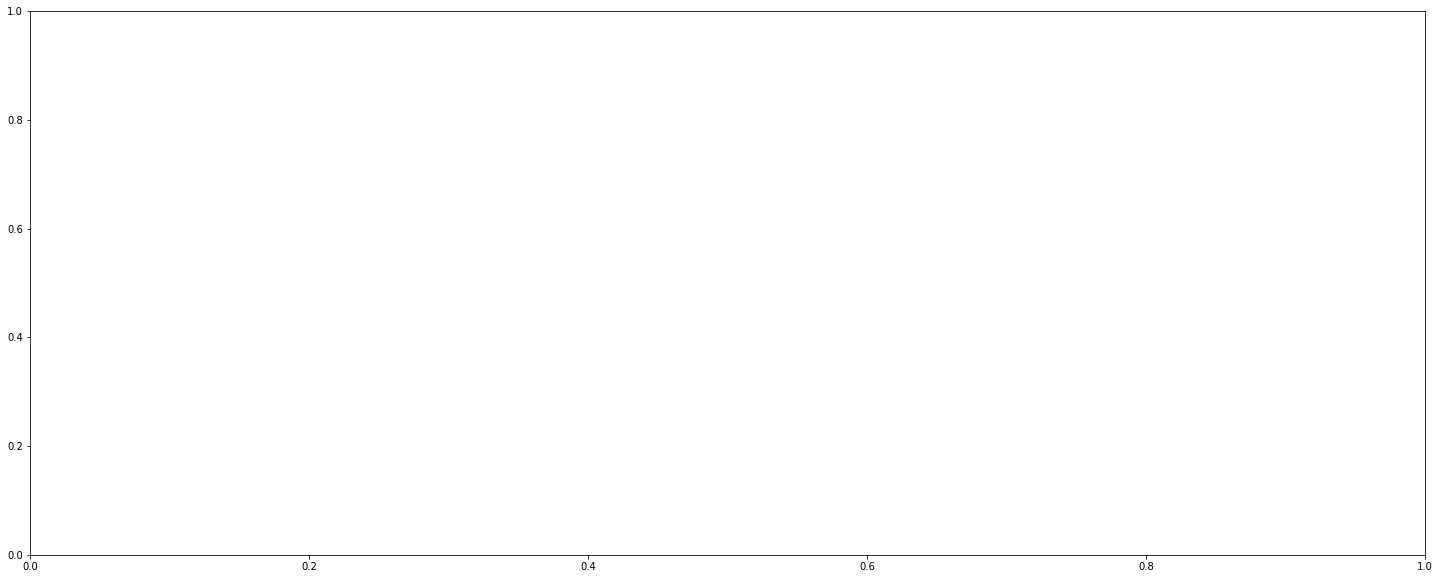

In [ ]:
# plot
geo_county.plot(column='per_capita_income',scheme="quantiles",figsize=(25,10),cmap='coolwarm')
plt.xlim(-130,-60)
plt.ylim(20,55)
plt.title('Median Income by County',fontsize=20)
# add state borders
# zoom on state
plt.show()